In [186]:
#start the connection to Azure Blob Storage
from azure.storage.blob import BlobService
import pandas as pd

#connect to your blob storage account
blob_service = BlobService(account_name='YourAccount', account_key='YourKey')

#get the latest dataset that was scored
#we temporarely store the data in a local CSV file
blob_service.get_blob_to_path('amltest', 'output.csv', 'tmp.csv')


In [187]:
#convert text file into Pandas DataFrame
data =  pd.read_csv("tmp.csv")

#Remove the whitespace from the columns names to avoid Python errors
cols = data.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
data.columns = cols



In [188]:
#print the first 10 lines to get an idea what data we have
#in this example we have label, 10 variables, and the scored label with probability. 
print data.head(n=10)

#to get an idea how many rows/cols of data we have
print data.shape

   Col1  Var1  Var2  Var3  Var4  Var5  Var6  Var7  Var8  Var9  Var10  \
0    -1     0     0     0     0     0   700    14     0     0      0   
1    -1     0     0     0     0     0    42     0     0     0      0   
2    -1     0     0     0     0     0  1064     7     0     0      0   
3    -1     0     0     0     0     0  1771     7     0     0      0   
4    -1     0     0     0     0     0  2338     7     0     0      0   
5    -1     0     0     0     0     0   833     0     0     0      0   
6    -1     0     0     0     9     0     0     0     0     0      0   
7    -1     0     0     0     0     0   784     7     0     0      0   
8    -1     0     0     0     0     0   462     0     0     0      0   
9    -1     0     0     0     0     0  4473     7     0     0      0   

   Scored_Labels  Scored_Probabilities  
0             -1          3.549297e-07  
1             -1          3.026316e-06  
2             -1          4.539386e-07  
3             -1          6.045643e-06  
4 

In [189]:
#create a frequency table on our Scored Labels to see how many of each case we have
data['Scored_Labels'].value_counts()

-1    24483
 1      267
Name: Scored_Labels, dtype: int64

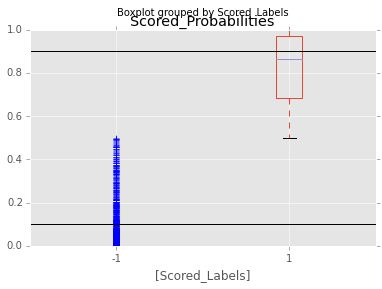

In [190]:
#to get an idea how well our model is working we plot the distribution of Probabilities for each Scored Label.

import matplotlib
matplotlib.style.use('ggplot')
plt = data.boxplot(column=['Scored_Probabilities'], by=['Scored_Labels'])
#add 2 lines for the 10% probability score
plt.axhline(y=.1, xmin=0, xmax=1, linewidth=1, color = 'k')
plt.axhline(y=.9, xmin=0, xmax=1, linewidth=1, color = 'k')
plt

In [191]:
from __future__ import division
#For class 1 we would like to know what the ratio of confident (>=0.9) vs non-confident (<0.9) Scored Labels is. 
#We first select to DataFrames with the different confidences
data_c1_good = data.query("Scored_Labels == 1 and Scored_Probabilities >= 0.9")
data_c1_bad = data.query("Scored_Labels == 1 and Scored_Probabilities < 0.9")
class1rate = (len(data_c1_good) /  (len(data_c1_good) + len(data_c1_bad)))
#We calculate the percentage of Scored Lables that fit our criteria
print  "Scored Label: 1, high confidence rate = "+ `class1rate`

#Same calculation, now for the Scored Labels -1 class, note that the probability threshold is different! 
data_c1_good = data.query("Scored_Labels == -1 and Scored_Probabilities <= 0.1")
data_c1_bad = data.query("Scored_Labels == -1 and Scored_Probabilities > 0.1")
class0rate = (len(data_c1_good) /  (len(data_c1_good) + len(data_c1_bad)))

#We calculate the percentage of Scored Lables that fit our criteria
print  "Scored Label: -1, high confidence rate = "+ `class0rate`

#Same calculation, now for the all classes, note that the probability threshold is different! 
data_c1_good = data.query("Scored_Probabilities >= 0.9 or Scored_Probabilities <= 0.1")
data_c1_bad = data.query("Scored_Probabilities < 0.9  and Scored_Probabilities > 0.1")
classallrate = (len(data_c1_good) /  (len(data_c1_good) + len(data_c1_bad)))
#We calculate the percentage of Scored Lables that fit our criteria
print  "Scored Label: all, high confidence rate = "+ `classallrate`


Scored Label: 1, high confidence rate = 0.43820224719101125
Scored Label: -1, high confidence rate = 0.9874198423395826
Scored Label: all, high confidence rate = 0.9814949494949495


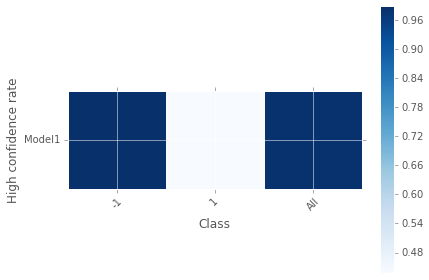

In [192]:
import matplotlib.pyplot as plt
import numpy as np

#We make a matrix to put our rates in
#When we would have several models or different datasets we could compare the results at once
plotMat = [[class0rate, class1rate,classallrate]]
plt.imshow(plotMat, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
x_tick_marks = np.arange(3)
y_tick_marks = np.arange(1)
plt.xticks(x_tick_marks, ['-1', '1', 'All'], rotation=45)
plt.yticks(y_tick_marks, ['Model1'])
plt.tight_layout()
plt.ylabel('High confidence rate')
plt.xlabel('Class')